## Codificación guiada por la variable objetivo o target

En las lecciones anteriores de esta sección, vimos como convertir una etiqueta en un número usando codificación one-hot, reemplezando por un dígito o reemplazando por la frecuencia o número de observaciones. Estos métodos son sencillos, y no (o casi nunca) hacen supuestos y funcionan generalmente bien en una variedad de escenarios.

Hay métodos que por el contrario si permiten capturar  información y a la vez pre-procesar las etiquetas de una variable categórica. Estos métodos incluyen:

- Ordernar las etiquetas de acuerdo al target
- Reemplazar las etiquetas por el promedio del target (codificación por la media / por el target) 
- Reemplazar las etiquetas por el radio de probabilidad del target ser ya sea 1 o 0
- Pesos de evidencia (Weight of evidence)

Todos estos métodos tienen algo en común:
- la codificación es **guiada por el target**, y
- crean una **relación monotónica** entre la variable y el target


### Monoticidad

Una relación monotónica es una relacion que tiene lo siguiente:

- (1) cuando el valor de una variable incrementa, asi mismo sucede con la otra variable; o
- (2) cuando el valor de una varaible incrementa, el valor de la otra variable decrece.

En este caso, si el valor de la variable independiente ( predictor) incrementa, lo mismo sucede con el target, o por el contrario, si la variable incrementa, el valor del target decrece.


### Ventajas 

- Captura la informacion dentro de la categoria, por lo tanto incrementa el poder predictivo de las variables.
- Crea una relación monotónica entre la varaible y el target, por lo tanto es adecuada para modelos lineales.
- No expande el espacio de las variables


### Limitaciones

- Tiende a causar sobreajustes
- Es dificil de validar usando las librerias existentes

### Nota

Los métodos discutidos en esta y las próximas 3 lecciones pueden ser also usados con variables numéricas, luego de discretizarlas. Esto crea una relación monotónica entre la variable numérica y el target y por lo tanto mejora el desempeño de los modelos lineales. Discutiremos esto en mas detalle en la sección "Discretización"

===============================================================================


## Codificación por la media del target

La codificación por la media implica reemplazar cada categoría por el promedio o la media del valor del target para dicha categoría. Por ejemplo, si tenemos la variable ciudad, con las categorías de Londres, Manches y Bristol, y queremos predecir cual es la tasa promedio de incumplimiento (para pagos de préstamos), y tenemos que el valor promedio dicha tasa de incumplimiento es 30% para Londres, reemplazamos Londres con 0.3, si la tasa es 20% para Manchester, reemplazamos con 0.20 y asi sucesivamente.

Vamos a realizar codificación one hot con:
- pandas
- Feature-Engine

y las ventajas y limitaciones de cada una de estas implementaciones usando los datos del Titanic.




In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# separar los datos
from sklearn.model_selection import train_test_split

# codificación con  feature-engine
from feature_engine.categorical_encoders import MeanCategoricalEncoder

In [3]:
# cargar datos

data = pd.read_csv(
    '../titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [4]:
# llenar valores ausentes na en la variable embarked

data['embarked'].fillna('Missing', inplace=True)

In [5]:
# Ahora extraemos la primearaNow we extract the first letter of the cabin
# to create a simpler variable for the demo

data['cabin'] = data['cabin'].astype(str).str[0]

In [6]:
# miremos cuantas caegorias tiene cada variable

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

survived :  2  labels
sex :  2  labels
cabin :  9  labels
embarked :  4  labels


In [7]:
# exploremos las categorias únicas

data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'T', 'F', 'G'], dtype=object)

In [8]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [9]:
data['embarked'].unique()

array(['S', 'C', 'Missing', 'Q'], dtype=object)

### Importante sobre codificación

Calculamos la media del target por cada categoría usando el segmento de entrenamiento; y luego usamos este mapeo para codificar las variables en el segmento de prueba

**Para usar esta técnica con pandas, necesitmaos mantener el target en el segmento de entrenamiento**

In [10]:
# separemos en segmentos de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']], # esta vez mantenemos el target en la variable
    data['survived'],  # target
    test_size=0.3,  # percentaje de observaciones en el segmento de prueba
    random_state=0)  # seed asegurar reproducibilidad

X_train.shape, X_test.shape

((916, 4), (393, 4))

### Exploremos la relación original entre las variables categóricas y el target

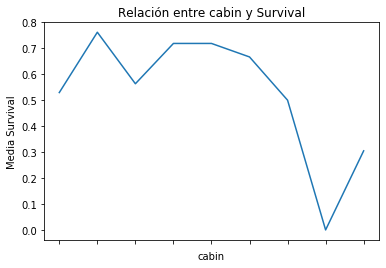

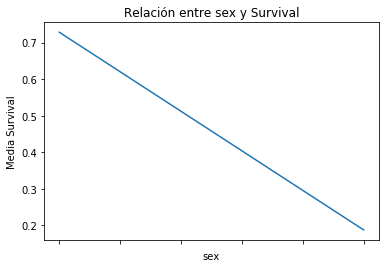

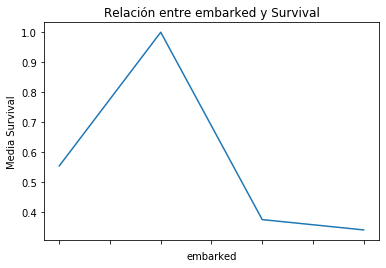

In [11]:
# Exploremos la relación original entre las variables categóricas y el target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relación entre {} y Survival'.format(var))
    fig.set_ylabel('Media Survival')
    plt.show()

Podemos ver que la relación entre el target y cabin, embarked sube y baja dependiendo de la categoría. 


## Codificación por la media con pandas

### Ventajas

- rápido
- retorna un pandas dataframe

### Limitaciones:

- no preserva la información del segmento de entrenamiento para propagarlo al segmento de prueba

Necesitamos capturar y guardar los mapeos uno por uno, manualmente, si estamos planeando usarlos en producción


In [12]:
# calculemos el promedio del target para cada categoria
X_train.groupby(['cabin'])['survived'].mean()

cabin
A    0.529412
B    0.761905
C    0.563380
D    0.718750
E    0.718750
F    0.666667
G    0.500000
T    0.000000
n    0.304843
Name: survived, dtype: float64

In [13]:
# hagamos lo mismo pero capturemos la información en un diccionario

ordered_labels = X_train.groupby(['cabin'])['survived'].mean().to_dict()

ordered_labels

{'A': 0.5294117647058824,
 'B': 0.7619047619047619,
 'C': 0.5633802816901409,
 'D': 0.71875,
 'E': 0.71875,
 'F': 0.6666666666666666,
 'G': 0.5,
 'T': 0.0,
 'n': 0.30484330484330485}

In [14]:
# ahora, reemplacemos las etiquetas con el promedio del target
X_train['cabin'] = X_train['cabin'].map(ordered_labels)
X_test['cabin'] = X_test['cabin'].map(ordered_labels)

In [15]:
# exploremos el resultado

X_train['cabin'].head(10)

501     0.304843
588     0.304843
402     0.304843
1193    0.304843
686     0.304843
971     0.304843
117     0.718750
540     0.304843
294     0.563380
261     0.718750
Name: cabin, dtype: float64

In [16]:
# agrupemos los comandos anteriores en dos funciones

def find_category_mappings(df, variable, target):
    return df.groupby([variable])[target].mean().to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    X_train[variable] = X_train[variable].map(ordinal_mapping)
    X_test[variable] = X_test[variable].map(ordinal_mapping)

In [17]:
# ahora repitamos con un ciclo para cada una de las variables categoricas

for variable in ['sex', 'embarked']:
    mappings = find_category_mappings(X_train, variable, 'survived')
    integer_encode(X_train, X_test, variable, mappings)

In [18]:
# veamos el resultado 
X_train.head()

,cabin,sex,embarked,survived
501,0.304843,0.728358,0.338957,1
588,0.304843,0.728358,0.338957,1
402,0.304843,0.728358,0.553073,1
1193,0.304843,0.187608,0.373494,0
686,0.304843,0.728358,0.373494,1


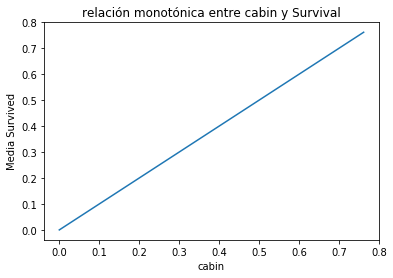

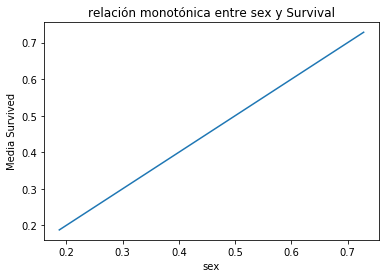

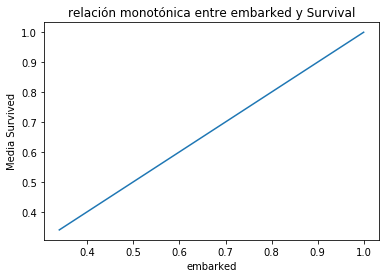

In [20]:
# inspeccionemos la relación monotónica
# entre la variable y el target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('relación monotónica entre {} y Survival'.format(var))
    fig.set_ylabel('Media Survived')
    plt.show()

Podemos ver de las gráficas que la relación entre las categorias y el target ahora es monotónica.

### Nota
Reemplazar las etiquetas con código anterior siguiendo este método va a generar valores faltantes para las categorias presentes en el segmento de prueba que no se encuentra en el de entrenamiento. Por lo tanto es extremadamente importante, manejar las etiquetas poco comunes con prelación. Explicaremos como hacer esto más adelante en otro notebook.


## ## Codificación por la media con Feature-Engine

Si usamos Feature-Engine, en lugar de pandas, no necesitamos mantener el target en el segmento de entrenamiento.

In [21]:
# separemos en segmentos de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']], # esta vez mantenemos el target en la variable
    data['survived'],  # target
    test_size=0.3,  # percentaje de observaciones en el segmento de prueba
    random_state=0)  # seed asegurar reproducibilidad

X_train.shape, X_test.shape


((916, 3), (393, 3))

In [22]:
mean_enc = MeanCategoricalEncoder(
    variables=['cabin', 'sex', 'embarked'])

In [23]:
# cuando ajustamos el transformador, necesitamos pasar el target
# tambien, como cualquier otro de los predictores en Scikit-learn 

mean_enc.fit(X_train, y_train)

MeanCategoricalEncoder(variables=['cabin', 'sex', 'embarked'])

In [24]:
# en el dict del encoder podemos ver el promedio del target
# asignado a cada una de las categorias por cada variable
mean_enc.encoder_dict_

{'cabin': {'A': 0.5294117647058824,
  'B': 0.7619047619047619,
  'C': 0.5633802816901409,
  'D': 0.71875,
  'E': 0.71875,
  'F': 0.6666666666666666,
  'G': 0.5,
  'T': 0.0,
  'n': 0.30484330484330485},
 'sex': {'female': 0.7283582089552239, 'male': 0.18760757314974183},
 'embarked': {'C': 0.553072625698324,
  'Missing': 1.0,
  'Q': 0.37349397590361444,
  'S': 0.3389570552147239}}

In [ ]:
# esta es la lista de variables que el codificador transforma


mean_enc.variables

In [ ]:
X_train = mean_enc.transform(X_train)
X_test = mean_enc.transform(X_test)

# exploremos los resultados
X_train.head()

**Nota**

Si el argmento 'variables' se fija en 'None' (ninguno), entonces el codificador automaticamente indentificará  **todas las variables categóricas**. Maravilloso verdad?

El codificador no codificará las variables numéricas. Por lo tanto, si algunas de tus variables categoricas son de hecho numericas, necesita hacer el 're-cast' o cambio como 'object' antes de usar el codificador.

Si hay una variable en el segmento de prueba, para el cual el codificador no tiene un número para asignar ( la categoria no estaba presente en el segmento de entrenamiento), el codificador devolvera un error, para alertarte del problema
